In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx
import pystan_utils
import itertools

plt.style.use('ggplot')
%matplotlib inline

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


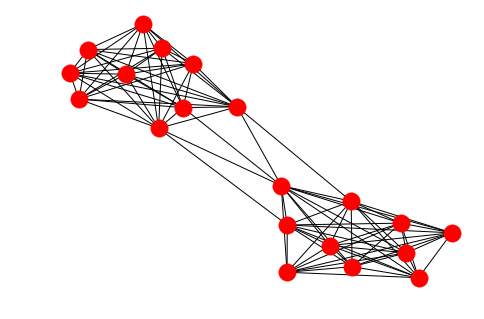

In [2]:
num_each = 20
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 5
between = 10
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T


mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)

mat[0,-1] = mat[-1,0] = np.random.poisson(between)
mat[0,-2] = mat[-2,0] = np.random.poisson(between)
mat[1,-2] = mat[-2,1] = np.random.poisson(between)
mat[2,-2] = mat[-2,2] = np.random.poisson(between)
mat[2,-3] = mat[-3,2] = np.random.poisson(between)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [3]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [4]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3be6d669e276c97fe04930ee9ae1728c NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpp6jn3zre/stanfit4anon_model_3be6d669e276c97fe04930ee9ae1728c_118772829557635824.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
n = num_each
k = 2
#alpha = sparse_alpha(5, k)
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1, 'c':5, 'd':3}
fit = sm.vb(data=data, iter=10000)

In [6]:
pies = pystan_utils.vb_extract_variable(fit, "pi", var_type="matrix", dims=[k,n])

In [7]:
extract = pystan_utils.vb_extract(fit)

In [8]:
groups = np.argmax(pies,axis=0)

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


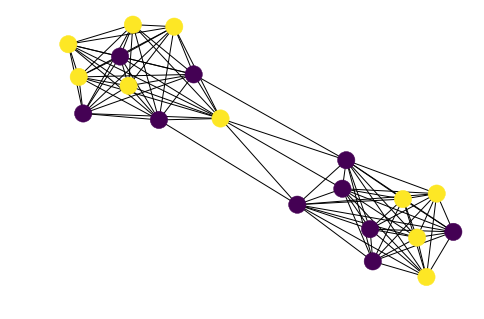

In [9]:
#pi = pies
#groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

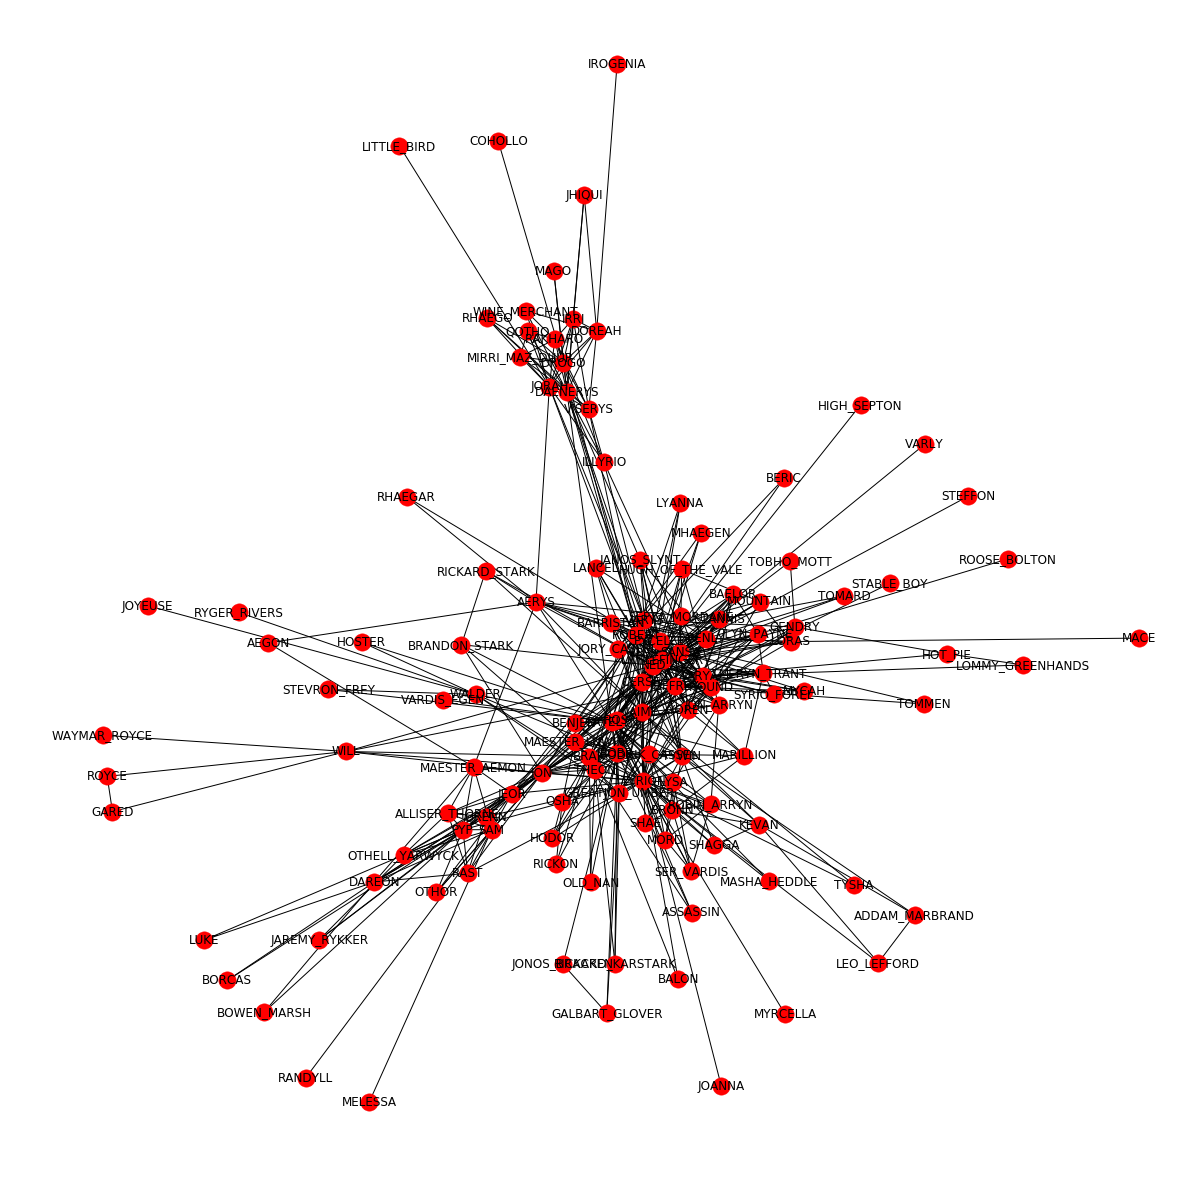

In [10]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s1-nodes.csv')
edges = pd.read_csv('../data/got-s1-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,16))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [11]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha


In [12]:
n = graph.shape[0]
k = 5
iterations = 10000
alpha = np.ones(k)
#alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.1, 'b' :  0.1, 'c': 0.5,'d': 0.5}

In [13]:
fit = sm.vb(data = data, iter = iterations, output_samples = iterations)

In [14]:
fitvar = pystan_utils.vb_extract(fit)

In [15]:
var_names = fit["sampler_param_names"]
samples = np.array([x for x in fit["sampler_params"]])

(array([2.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 1.500e+01, 4.900e+01,
        2.240e+02, 1.027e+03, 4.378e+03, 4.294e+03]),
 array([0.93720839, 0.9433211 , 0.94943381, 0.95554653, 0.96165924,
        0.96777195, 0.97388466, 0.97999737, 0.98611008, 0.9922228 ,
        0.99833551]),
 <a list of 10 Patch objects>)

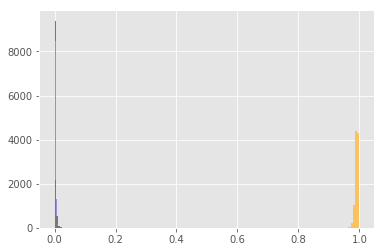

In [16]:
# Ned stark
plt.hist(fitvar[0]['pi[76,1]'])
plt.hist(fitvar[0]['pi[76,2]'])
plt.hist(fitvar[0]['pi[76,3]'])
plt.hist(fitvar[0]['pi[76,4]'])
plt.hist(fitvar[0]['pi[76,5]'])


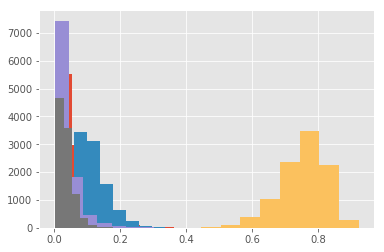

In [17]:
# Robert
plt.hist(fitvar[0]['pi[94,1]'])
plt.hist(fitvar[0]['pi[94,2]'])
plt.hist(fitvar[0]['pi[94,3]'])
plt.hist(fitvar[0]['pi[94,4]'])
plt.hist(fitvar[0]['pi[94,5]'])
plt.show()

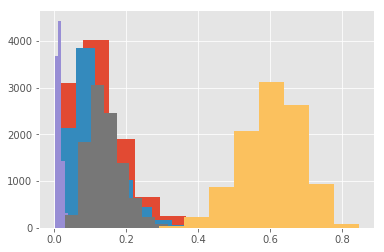

In [18]:
# Cersei
plt.hist(fitvar[0]['pi[18,1]'])
plt.hist(fitvar[0]['pi[18,2]'])
plt.hist(fitvar[0]['pi[18,3]'])
plt.hist(fitvar[0]['pi[18,4]'])
plt.hist(fitvar[0]['pi[18,5]'])
plt.show()

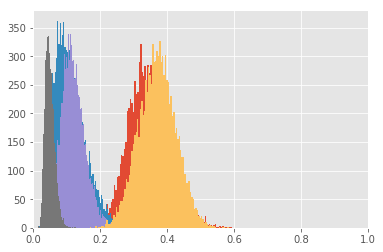

In [19]:
## Varys
plt.hist(fitvar[0]['pi[121,1]'], bins = 100)
plt.hist(fitvar[0]['pi[121,2]'], bins = 100)
plt.hist(fitvar[0]['pi[121,3]'], bins = 100)
plt.hist(fitvar[0]['pi[121,4]'], bins = 100)
plt.hist(fitvar[0]['pi[121,5]'], bins = 100)
plt.xlim(0,1)
plt.show()

(0, 1)

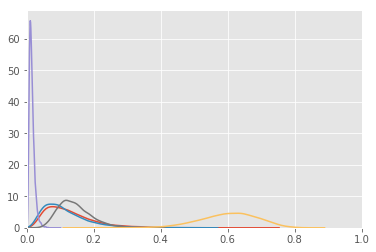

In [20]:
import seaborn as sns
sns.distplot(fitvar[0]['pi[18,1]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,2]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,3]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,4]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,5]'], kde=True, hist=False)
plt.xlim(0, 1)

In [21]:
for key in fitvar[0]:
    if "pi" in key:
        temp.append(fitvar[0][key])
        

NameError: name 'temp' is not defined

In [ ]:
test = temp[0]

In [ ]:
test.reshape(10000)

In [ ]:
lol =(np.array(temp))

In [ ]:
temp[0][0]

In [ ]:
temp[0]

In [ ]:
final = np.reshape(lol, (iterations, n, 6))

In [ ]:
fix = np.zeros([iterations,n,6])

In [ ]:

for i in range(0, iterations):
    for j in range(0,n):
        for z in range(0,6):
            fix[i,j,z] = temp[]

In [ ]:
k = 6

In [ ]:
extract = pystan_utils.vb_extract(fit)
pitest = np.zeros((k,n,iterations))
for ki in range(1,k+1):
    for ni in range(n):
        for it in range(1001):
            pitest[ki-1,ni,it] = extract[0][extract[2][(ki-1)*n + ni]][it]

In [ ]:
np.shape(pitest)

In [ ]:
pi = fit.extract()["pi"]

In [ ]:
groups = np.argmax(pi,axis = 1)

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

In [ ]:
groups = fit.extract()["pi"]

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [ ]:
scores = []
for i in range(1, iterations//2):
    cluster1 = np.argmax(groups[i-4], axis = 1)
    cluster2 = np.argmax(groups[i-3], axis = 1)
    scores.append(adjusted_mutual_info_score(cluster1, cluster2))

In [ ]:
plt.plot(scores)

In [ ]:
groups = np.argmax(pi_hat,axis = 0)

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

# Prediction code


We note that
$$p(x_{ij} | X) = \sum_{\boldsymbol{\pi},\lambda} p(x_{i,j}|\boldsymbol{\pi},\lambda)p(\boldsymbol{\pi},\lambda|X)$$
where $\boldsymbol{\pi}$ is the collection of all group membership vectors, and $X$ is the network with all missing links excluded. This can be approximated by
$$p(x_{ij} | X) \approx \frac{1}{M} \sum_{m=1}^M p(x_{i,j} | \boldsymbol{\pi}^{(m)},\lambda^{(m)}, X) = \frac{1}{M} \sum_{m=1}^M \text{Poisson}({\boldsymbol{\pi}_i^{(m)}}^T \lambda^{(m)}\boldsymbol{\pi}_j^{(m)})$$
where $\boldsymbol{\pi}^{(m)}$ is the $m$'th posterior sample of $\boldsymbol{\pi}$ and similarly for $\lambda$.

In [50]:
model_code_pred= """
functions{ 
          // From: https://discourse.mc-stan.org/t/stan-equivalent-of-rs-in-function/3849
          
          // function that is comparable to R's %in% function
          // pos is the value to test for matches
          // array pos_var is the 1-dimensional array of possible matches
          // returns pos_match=1 if pos matches at least one element of pos_var and pos_match=0 otherwise
          // example code: 
          // if(r_in(3,{1,2,3,4})) will evaluate as TRUE
          int r_in(int pos,int[] pos_var) {
            int pos_match;
            int all_matches[size(pos_var)];
    
            for (p in 1:(size(pos_var))) {
              all_matches[p] = (pos_var[p]==pos);
            }
    
            if(sum(all_matches)>0) {
              pos_match = 1;
            } else {
              pos_match = 0;
            }
            return pos_match;
            }
}
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
        
        int N_missing;
        int i_obs[N*N - N_missing];             // Indeces of kept links
        int j_obs[N*N - N_missing];
        int i_mis[N_missing];                // indeces of missing links
        int j_mis[N_missing];
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                if (r_in(i, i_obs) && r_in(j, j_obs)) { // check if observed
                    X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
                }
            }
        }
 
} generated quantities {
        int count = 0;
        int preds[N_missing];
        
        real scores[N_missing];
        
        // compute scores (ie how likely is the current weight) and make an actual prediction using the samples and then average over samples.
        for (i in 1:(N-1)) {
            for (j in (i+1):N) {
                if (r_in(i, i_mis) && r_in(j, j_mis)) {
                    preds[count] = poisson_rng(pi[i]'*lambda*pi[j]);
                    scores[count] = poisson_lpmf(X[i,j] | pi[i]'*lambda*pi[j]);
                    count = count + 1;
                }
            }
        }
}
"""

In [51]:
sm_pred = pystan.StanModel(model_code=model_code_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7bd2582956221694bc10e7c464f777f7 NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp0ma99jrv/stanfit4anon_model_7bd2582956221694bc10e7c464f777f7_4669596668338906789.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [52]:
def get_missing(N, N_missing):
    # Takes number of nodes N and how many nodes to hold out. This is absolutely hacky and the actual number of N_missing might be slightly smaller than the input the to the way the missing edges are picked.
    # Returns (actual) number of missing links, indeces of missing links and indeces of kept links including diagonal elements. These are skipped by STAN
    
    all_data = list(itertools.product(range(N), range(N)))
    #N_missing = int(len(all_data)*frac)
    # remove diagonal elements 
    for edge in all_data:
        if edge[0] == edge[1]:
            all_data.remove(edge)
    
    # find missing indeces
    missing_idx = np.random.choice(len(all_data), N_missing//2, replace=True)
    missing_edges = set([all_data[i] for i in missing_idx])
    reverse = set([(j,i) for (i,j) in missing_edges if (j,i) not in missing_edges])
    missing_edges.update(reverse)
    
    keep_edges = [x for x in all_data if x not in missing_edges]
    keep_edges += [(i,i) for i in range(N)]
    
    return len(missing_edges), list(missing_edges), list(keep_edges)

In [53]:
N_missing, missing_edges, keep_edges = get_missing(n, int(0.05*n))
missing_i, missing_j = zip(*missing_edges)
obs_i, obs_j = zip(*keep_edges)

data_pred = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.1, 'b' :  0.1, 'c': 0.5,'d': 0.5, 'N_missing' : N_missing, 'i_obs' : obs_i, 'j_obs' : obs_j, 'i_mis' : missing_i, 'j_mis' : missing_j}

In [ ]:
fit_pred = sm_pred.vb(data=data_pred,iter=iterations, output_samples = iterations)